In [2]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

In [66]:
# setup qiskit using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm = Aer.get_backend('qasm_simulator')
stv = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')

ibmqfactory.load_account:WARNING:2022-06-22 00:25:56,194: Credentials are already in use. The existing account in the session will be replaced.


## Probing the nature of Boolean Functions !

For a boolean function $ f: \{0,1\}^n \to \{1,0\} $ we want to find the number of inputs $\mathbf{x \in X_1}$ such that, $f(\mathbf{x}) = 1 $ and the number of inputs $\mathbf{x \in X_0}$ such that $f(\mathbf{x}) = 0 $, i.e to estimate $|X_1|$ and $|X_0|$.

This is kinda' an plausible extension to the vanilla Deustch-Josza algorithm !

For our problem, $x \in \{0,1\}^4$ , and the oracle function is $f(x_1,x_2,x_3,x_4) = x_1x_2 + x_3x_4$

So out of all 16 possible values of $x$, there are 7 values such that $f(x) = 1$ and 9 values such that $f(x) = 0$.

Thus, $|X_1 |= 7$ and $|X_0| = 9$

In [123]:
def oracle_f(nq= 4):
    qreg, ancilla = QuantumRegister(nq), QuantumRegister(1)
    qc = QuantumCircuit(qreg, ancilla, name= 'oracle')
    qc.x(ancilla)
    qc.h(ancilla)
    qc.mcx([0,1], ancilla)
    qc.mcx([2,3], ancilla)
    qc.mcx([0,1,2,3], ancilla)
    qc.h(ancilla)
    qc.x(ancilla)
    return qc.to_gate()

In [129]:
qreg, ancilla_1, ancilla_2 , creg = QuantumRegister(4, name= 'qreg'), QuantumRegister(1, name= 'ancilla_1'), QuantumRegister(1, name= 'ancilla_2'), ClassicalRegister(1, name='creg')
qc = QuantumCircuit(qreg, ancilla_1, ancilla_2, creg)
qc.h(ancilla_2)
qc.h(qreg)
qc.barrier()
qc.append( oracle_f().control(1, label='controlled_oracle'),  [5,0,1,2,3,4])
qc.h(ancilla_2)

    
# qc.decompose().draw()        
qc.draw()    

┌───┐ ░     ┌─────────┐         
   qreg_0: ┤ H ├─░─────┤0        ├─────────
           ├───┤ ░     │         │         
   qreg_1: ┤ H ├─░─────┤1        ├─────────
           ├───┤ ░     │         │         
   qreg_2: ┤ H ├─░─────┤2 oracle ├─────────
           ├───┤ ░     │         │         
   qreg_3: ┤ H ├─░─────┤3        ├─────────
           └───┘ ░     │         │         
ancilla_1: ──────░─────┤4        ├─────────
           ┌───┐ ░     └────┬────┘    ┌───┐
ancilla_2: ┤ H ├─░──────────■─────────┤ H ├
           └───┘ ░  controlled_oracle └───┘
   creg: 1/════════════════════════════════

In [126]:
shots = 11024
qc.measure(ancilla_2, creg)
job = execute(qc, backend= aer, shots= shots)
counts = job.result().get_counts()

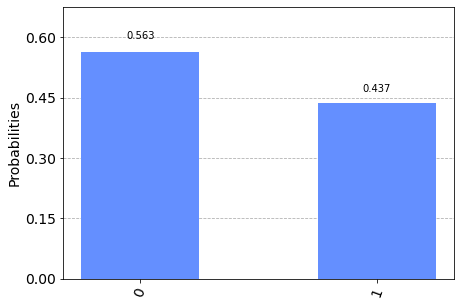

In [127]:
plot_histogram(counts)

In [128]:
print('|X1| :', counts['1']*16/shots)
print('|X0| :', counts['0']*16/shots)


|X1| : 6.9912917271407835
|X0| : 9.008708272859216


Which is close enough to out orginal values!

** Note that we needed just one qubit measurement whereas in the usual DJ algotithm we would have needed to measure all the qubits in ```qreg```, also we didn't need the final layer of ```hadamard``` gates !